# Gene prediction targets
Overexpressing essential genes in metabolic pathways is a commonly employed method to enhance the production of a desired molecule. As the increased production of naturally synthesized compounds typically involves genetic modification to metabolic pathways, a crucial initial step is to identify the critical pathways and specific genes to guide strategies for overexpressing or downregulating genes in subsequent manipulations [1].

**Cameo** provides algorithms to search for genes or reactions that can be over or down regulated in order to achieve a given biological objective: Flux Scanning based on Enforced Objective Flux (FSEOF) [2]. In this case our biological objective would be to optimize the flux towards the production of Ethylene. 

**FSEOF** scans all the metabolic fluxes in the metabolic model and selects fluxes that change when the flux toward product formation is enforced (gradually increased) as an additional constraint during flux analysis.

In [1]:
from cobra.io import read_sbml_model
model = read_sbml_model('/workspaces/group-assingment-group-2/models/modified_model.xml')

In [2]:
from collections.abc import Mapping

In [5]:
from cameo import models
from cameo.strain_design.deterministic.flux_variability_based import FSEOF

In [12]:
fseof = FSEOF(model)
result = fseof.run(target=model.reactions.EFE_m)
df = result.data_frame
df

,1,2,3,4,5,6,7,8,9,10
ACALD,0.000000,0.000000,0.000000,0.000000,0.338702,2.098387,4.437898,5.226580,5.600629,5.974677
ACCOAL,0.000000,0.000000,0.000000,0.286491,0.308175,0.259659,0.209736,0.158903,0.107827,0.056751
ACONTa,4.988129,5.118482,5.252141,5.389344,6.382563,7.433429,8.481412,9.527532,10.573152,11.618773
ACONTb,4.988129,5.118482,5.252141,5.389344,6.382563,7.433429,8.481412,9.527532,10.573152,11.618773
ACS,0.527141,0.481976,0.436713,0.391343,0.342063,0.288212,0.232800,0.176377,0.119684,0.062992
...,...,...,...,...,...,...,...,...,...,...
TRPS1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022715,0.017209,0.011678,0.006146
VPAMTr,0.382896,0.350090,0.317212,0.284257,0.248462,0.209347,0.169097,0.128114,0.086934,0.045755
XYLI2,-0.000000,0.000000,0.163611,0.502661,0.365838,1.639877,3.805119,5.171160,6.323523,7.475887
RNTR1c2,0.023676,0.021648,0.019615,0.017577,0.015364,1.288331,3.491482,3.407482,2.711983,2.016485


The whole dataframe shows 85 rows, so we can conclude that there are 85 reactions that produce a change of flux.

After running the FSEOF analysis, we can plot the predicted targets that shows an increase or decrease in the flux when the target is set to the last step of the EFE_m reaction.

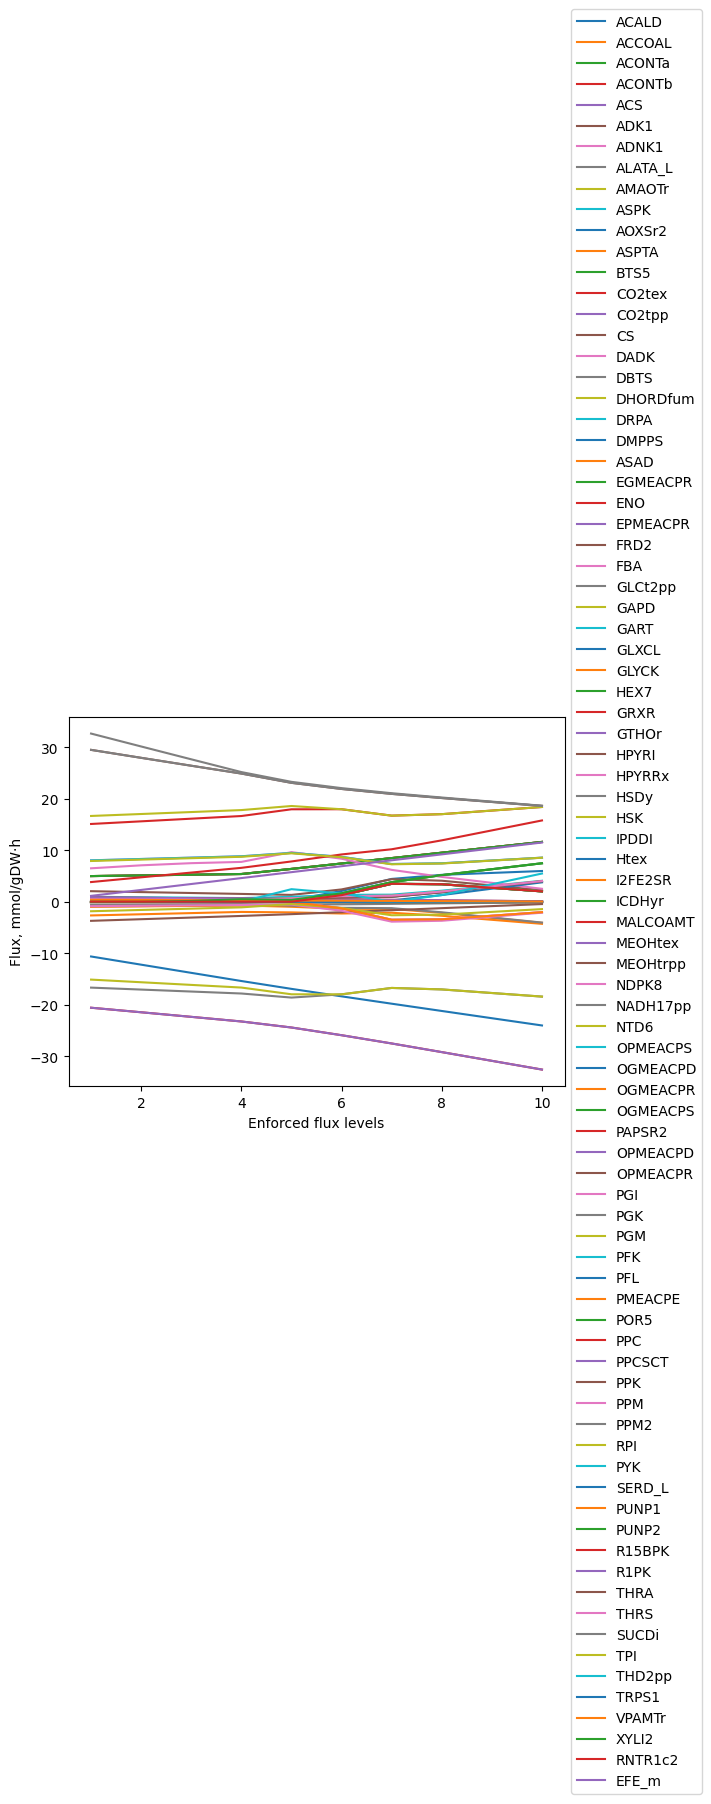

In [15]:
from matplotlib import pyplot as plt
result.data_frame.T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Enforced flux levels")
plt.ylabel("Flux, mmol/gDW·h")
plt.show()

Then, we can plot all of the data in a more representative way, where the genes with a positive change in the flux are represented in green and the ones with a negative change in the flux are shown in red:

/tmp/ipykernel_15146/1140286807.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.index, rotation=90, ha='center')


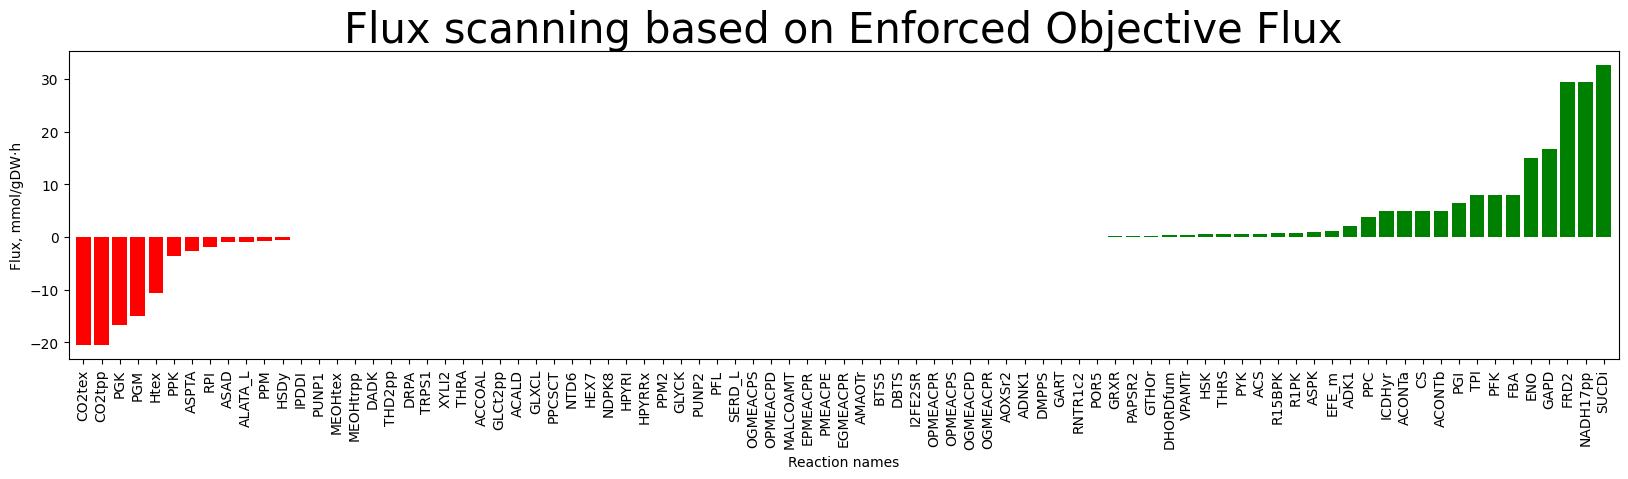

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = df.sort_values(by=df.columns[0], ascending=True)

def bar_color(df, color1, color2):
    return np.where(df.values >= 0, color1, color2)

fig, ax = plt.subplots(figsize=(20, 4))
bars = ax.bar(df.index, df[df.columns[0]], color=bar_color(df[df.columns[0]], 'green', 'red'))

ax.set_ylabel('Flux, mmol/gDW·h')
ax.set_xlabel('Reaction names')
ax.set_title('Flux scanning based on Enforced Objective Flux', size=30)

ax.set_xticklabels(df.index, rotation=90, ha='center')
ax.margins(x=0.005)


plt.show()


Next, we can delete all the targets that have a flux change of 0.0, so we can obtain the enzymes that show the highest increase or decrease in flux:

In [22]:
from pytest import approx
# removing genes from dataframe 
removed_zero = (df != approx(0.0)).all(axis=1)
df = df.loc[removed_zero]

### Downregulation

For obtaining which genes could be downregulated in order to increase the flux towards the production of ethylene, we filter the data to obtain the genes that produce a decrease in our target flux greater than 80% and statically significative: 

In [24]:
down = []
for row in range(len(df[1])):
        if df[1][row]>df[10][row] and abs(df[1][row]-df[10][row])/abs(df[1][row])>1.8 and df[1][row]-df[10][row]>0.1:
            down.append(df.index[row])
Reactions_down=df.T[down].T.sort_values(by=[10])
Reactions_down

/tmp/ipykernel_15146/676931688.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df[1][row]>df[10][row] and abs(df[1][row]-df[10][row])/abs(df[1][row])>1.8 and df[1][row]-df[10][row]>0.1:
/tmp/ipykernel_15146/676931688.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  if df[1][row]>df[10][row] and abs(df[1][row]-df[10][row])/abs(df[1][row])>1.8 and df[1][row]-df[10][row]>0.1:


,1,2,3,4,5,6,7,8,9,10
ASAD,-0.967349,-0.884467,-0.801404,-0.718147,-0.966416,-1.351894,-1.384079,-2.150687,-3.113652,-4.076617
HSDy,-0.631697,-0.577574,-0.523332,-0.468964,-0.748612,-1.168378,-1.235846,-2.038381,-3.037444,-4.036508
PUNP1,-0.000609,-0.000557,-0.000504,-0.000452,-0.000395,-1.275719,-3.481295,-3.399764,-2.706746,-2.013728
NDPK8,-0.000000,0.000000,0.000000,0.000000,0.000000,-1.275386,-3.481026,-3.399560,-2.706608,-2.013655
DADK,-0.000000,0.000000,0.000000,0.000000,0.000000,-1.275386,-3.481026,-3.399560,-2.706608,-2.013655


And represent this data in a plot:

Text(0.5, 1.0, 'Reactions that affects negatively to ethylene production with a relative change in Flux > 80%')

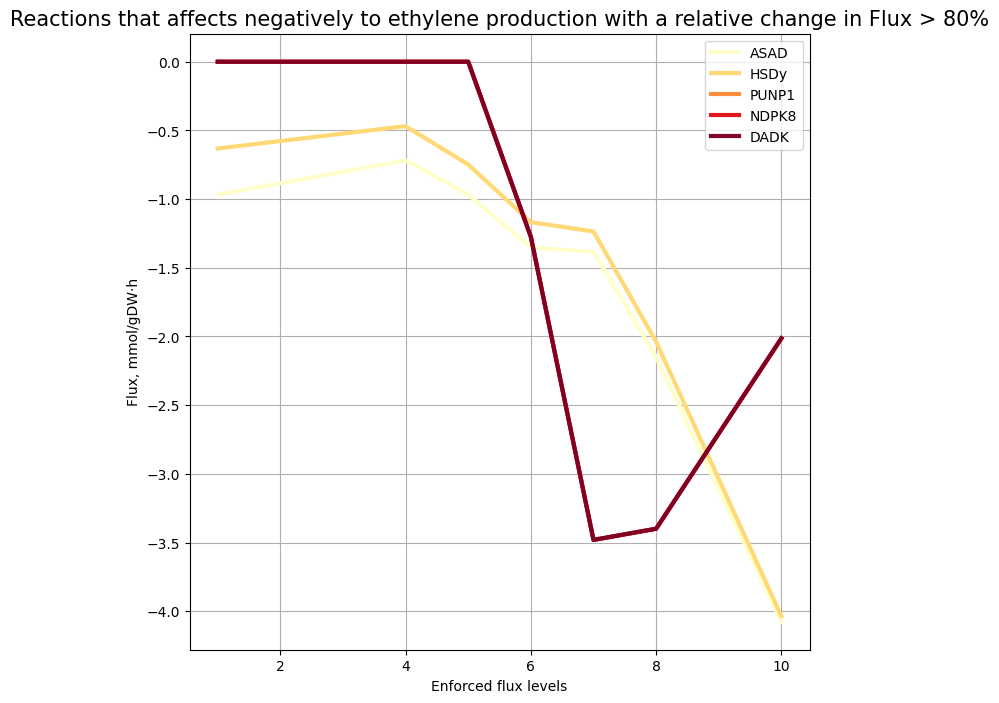

In [40]:
fig = Reactions_down.T.plot(cmap="YlOrRd",figsize=(8, 8), grid =True, linewidth=3);
fig.set_ylabel('Flux, mmol/gDW·h')
fig.set_xlabel('Enforced flux levels')
fig.set_title('Reactions that affects negatively to ethylene production with a relative change in Flux > 80%', size=15)

We can identify all these reactions by doing a search within our model:

In [5]:
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite
model = read_sbml_model('/workspaces/group-assingment-group-2/models/modified_model.xml')

In [60]:
reactions_to_check=list(Reactions_down.index)

for reaction in model.reactions:
    if reaction.id in reactions_to_check:
        print (reaction.id, ":", reaction.name)

DADK : Deoxyadenylate kinase
ASAD : Aspartate-semialdehyde dehydrogenase
HSDy : Homoserine dehydrogenase (NADPH)
NDPK8 : Nucleoside-diphosphate kinase (ATP:dADP)
PUNP1 : Purine-nucleoside phosphorylase (Adenosine)


### Overexpression

For obtaining which genes could be overexpressed in order to increase the flux towards the production of ethylene, we filter again the data to obtain the genes that produce an increase in our target flux statically significative: 

In [44]:
up = []
for row in range(len(df[1])):
        if df[1][row]==0.0:
            continue
        elif df[1][row]<df[10][row] and abs(df[10][row]-df[1][row])/abs(df[10][row])>0.95 and df[10][row]-df[1][row]>0.1:
            up.append(df.index[row])
Reactions_up=df.T[up].T.sort_values(by=[10])
Reactions_up

/tmp/ipykernel_15146/461494511.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df[1][row]==0.0:
/tmp/ipykernel_15146/461494511.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif df[1][row]<df[10][row] and abs(df[10][row]-df[1][row])/abs(df[10][row])>0.95 and df[10][row]-df[1][row]>0.1:
/tmp/ipykernel_15146/461494511.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  elif df[1][row]<df[10][row] and abs(df[10][row]-df[1][row])/abs(df[10][row])>0.95 and df[10][row]-df[1][row]>0.1:


,1,2,3,4,5,6,7,8,9,10
PPK,-3.697347,-3.380562,-3.063084,-2.744863,-2.399215,-2.021507,-1.632846,-1.237101,-0.839461,-0.441822
ALATA_L,-0.908934,-0.831057,-0.753010,-0.674781,-0.589808,-0.496955,-0.401409,-0.304121,-0.206368,-0.108615
ADNK1,0.000609,0.000557,0.000504,0.000452,0.000395,1.275719,3.481295,3.399764,2.706746,2.013728
RNTR1c2,0.023676,0.021648,0.019615,0.017577,0.015364,1.288331,3.491482,3.407482,2.711983,2.016485
POR5,0.098406,0.089975,0.081525,0.073056,0.063856,1.329190,3.524485,3.432486,2.728950,2.025415
GART,0.002220,0.002029,0.001839,0.001648,0.404265,0.878242,1.001492,1.860826,2.916961,3.973095


Text(0.5, 1.0, 'Reactions that affects positively to ethylene production')

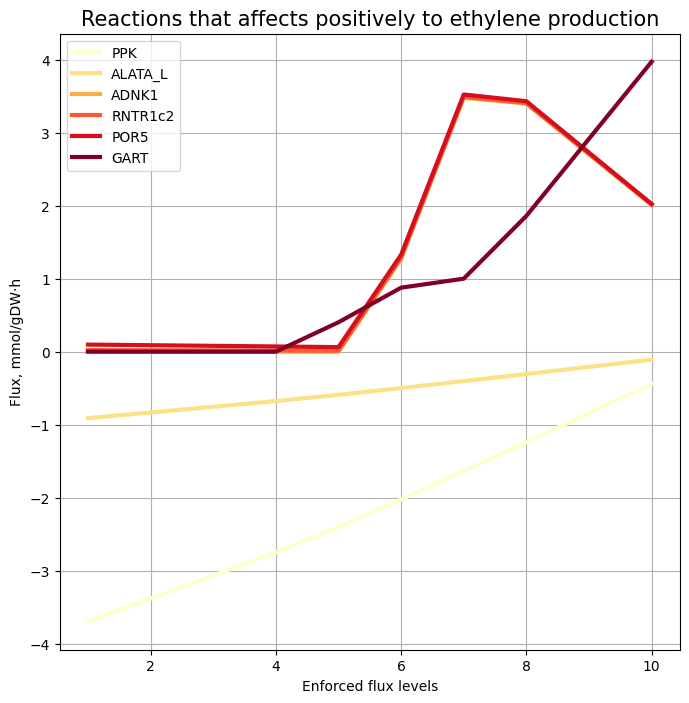

In [45]:
fig = Reactions_up.T.plot(cmap="YlOrRd",figsize=(8, 8), grid =True, linewidth=3);
fig.set_ylabel('Flux, mmol/gDW·h')
fig.set_xlabel('Enforced flux levels')
fig.set_title('Reactions that affects positively to ethylene production', size=15)

We identify all these reactions by doing a search within our model:

In [62]:
reactions_to_check=list(Reactions_up.index)

for reaction in model.reactions:
    if reaction.id in reactions_to_check:
        print (reaction.id, ":", reaction.name)

ADNK1 : Adenosine kinase
ALATA_L : L-alanine transaminase
GART : GAR transformylase-T
POR5 : Pyruvate synthase
PPK : Polyphosphate kinase
RNTR1c2 : Ribonucleoside-triphosphate reductase (ATP) (flavodoxin)


#### References
[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5699525/

[2] https://cameo.readthedocs.io/en/latest/06-predict-gene-modulation-targets.html?highlight=fseof

[3] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2869140/ 